In [4]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import modin.pandas as pd
import matplotlib.pyplot as plt

### Set hyperparameters

In [13]:
output_dir = 'model_output/conv'

# training
EPOCHS = 4
BATCH_SIZE = 128

# vector-space embedding
N_DIM = 64
N_UNIQUE_WORDS = 5000
MAX_REVIEW_LENGTH = 400 # we incresed the size of max review, cuz ConV can handle longers
PAD_TYPE = TRUNC_TYPE = 'pre'
DROP_EMBED = 0.2 # this is for Embedding Layer

# convolutional layer architecture
N_CONV = 256 # filters a.k.a. kernels
K_CONV = 3 # kernel length, looking for triplets tokens

# neural network architecture
N_DENSE = 256
DROPOUT = 0.2

In [9]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words = N_UNIQUE_WORDS)

### Preprocess 

In [11]:
X_train = pad_sequences(X_train, maxlen=MAX_REVIEW_LENGTH,
                      padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

X_valid = pad_sequences(X_valid, maxlen=MAX_REVIEW_LENGTH,
                      padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

### ConV Architecture

In [16]:
model = Sequential()

# first hidden layer --> Embedding Layer
model.add(Embedding(N_UNIQUE_WORDS, N_DIM, input_length=MAX_REVIEW_LENGTH))
model.add(SpatialDropout1D(DROP_EMBED))


# second hidden layer --> Dense Layer
model.add(Conv1D(N_CONV, K_CONV, activation='relu')) # image icin Conv2D kullanilir
model.add(GlobalMaxPooling1D())
model.add(Dropout(DROPOUT))

# third hidden layer --> Dense Layer
model.add(Dense(N_DENSE, activation='relu'))
model.add(Dropout(DROPOUT))


# output layer
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

### Compile Model

In [18]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [19]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [20]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train Model

In [21]:
model.fit(X_train, y_train,
         batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
         validation_data=(X_valid, y_valid),
         callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 25s 1ms/sample - loss: 0.4850 - accuracy: 0.7426 - val_loss: 0.2989 - val_accuracy: 0.8752
Epoch 2/4
25000/25000 [==============================] - 24s 970us/sample - loss: 0.2758 - accuracy: 0.8874 - val_loss: 0.3320 - val_accuracy: 0.8594
Epoch 3/4
25000/25000 [==============================] - 24s 974us/sample - loss: 0.2110 - accuracy: 0.9168 - val_loss: 0.2672 - val_accuracy: 0.8877
Epoch 4/4
25000/25000 [==============================] - 24s 973us/sample - loss: 0.1627 - accuracy: 0.9385 - val_loss: 0.3113 - val_accuracy: 0.8792


In [22]:
# Here the best epoch is 3rd epoch so we need to load that one

In [23]:
model.load_weights(output_dir+"/weights.03.hdf5")

### Evaluate

In [39]:
y_pred = model.predict_proba(X_valid)

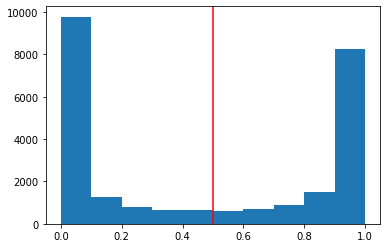

In [40]:
plt.hist(y_pred)
_ = plt.axvline(0.5, color='red')

In [41]:
pct_auc = roc_auc_score(y_valid, y_pred)*100.0
print(pct_auc)

95.93128288


In [42]:
float_y_pred = []
for y in y_pred:
    float_y_pred.append(y[0])

In [45]:
y_df = pd.DataFrame(list(zip(float_y_pred, y_valid)), columns=['y_pred', 'y_valid'])

In [46]:
y_df.head()

,y_pred,y_valid
0,0.038827,0
1,0.991014,1
2,0.924881,1
3,0.677172,0
4,0.990328,1
